[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Siddharth-Saravanan/StutterAssist/blob/main/reconstruct.ipynb)


In [ ]:
!pip install librosa soundfile fastdtw tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542084 sha256=bc3feed3ac1c9a82f7950129ef8f537e7ada94ea8af9101c1e796c07b1a55a8d
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import json
import shutil
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:


# Import libraries


# Define paths - USING YOUR SPECIFIC PATHS
LIBRISTUTTER_AUDIO_DIR = "/content/drive/MyDrive/pp2/Libristutter/Libristutter Audio"
LIBRISTUTTER_ANNOTATIONS_DIR = "/content/drive/MyDrive/pp2/Libristutter/Libristutter Annotations"
LIBRISPEECH_DIR = "/content/drive/MyDrive/pp2/Librispeech"
OUTPUT_DIR = "/content/drive/MyDrive/pp2/repetition_dataset"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Function definitions
def load_audio(audio_path, sr=16000):
    """Load audio file with error handling"""
    try:
        audio_path = audio_path.strip('"\'')
        audio, sr = librosa.load(audio_path, sr=sr)
        return audio, sr
    except Exception as e:
        print(f"Error loading audio file: {audio_path}")
        print(f"Error details: {e}")
        return None, None

def extract_mfcc(audio, sr=16000, n_mfcc=13):
    """Extract MFCC features from audio"""
    if audio is None:
        return None
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

def load_annotations(csv_path):
    """Load annotations from CSV file"""
    try:
        csv_path = csv_path.strip('"\'')
        df = pd.read_csv(csv_path)

        # Print sample to understand structure
        print(f"CSV sample from {os.path.basename(csv_path)}:")
        print(df.head(3))

        # Handle different column naming conventions
        if len(df.columns) >= 4:
            columns = df.columns.tolist()
            column_mapping = {
                columns[0]: 'word',
                columns[1]: 'start_time',
                columns[2]: 'end_time',
                columns[3]: 'stutter_flag'
            }
            df = df.rename(columns=column_mapping)

            # Convert to list of dictionaries
            annotations = []
            for _, row in df.iterrows():
                # Map stutter flag to type (adjust based on your dataset)
                stutter_type = None
                # Focus only on repetition-type stutters (flags 1, 2, 3)
                # Modify these mappings based on your CSV structure
                if row['stutter_flag'] == 1:
                    stutter_type = "sound_repetition"
                elif row['stutter_flag'] == 2:
                    stutter_type = "word_repetition"
                elif row['stutter_flag'] == 3:
                    stutter_type = "phrase_repetition"

                # Only include if it's a repetition stutter
                if stutter_type is not None:
                    annotations.append({
                        "word": row['word'],
                        "start_time": row['start_time'],
                        "end_time": row['end_time'],
                        "stutter_type": stutter_type
                    })

            return annotations
        else:
            print(f"CSV file has unexpected format: {csv_path}")
            return []
    except Exception as e:
        print(f"Error loading CSV file: {csv_path}")
        print(f"Error details: {e}")
        return []

def perform_dtw_alignment(stutter_audio, fluent_audio, sr=16000):
    """Perform DTW alignment between stuttered and fluent speech"""
    if stutter_audio is None or fluent_audio is None:
        return None, None

    # Extract MFCC features
    mfcc_stutter = extract_mfcc(stutter_audio, sr)
    mfcc_fluent = extract_mfcc(fluent_audio, sr)

    if mfcc_stutter is None or mfcc_fluent is None:
        return None, None

    # Transpose MFCCs to have time as first dimension
    mfcc_stutter = mfcc_stutter.T
    mfcc_fluent = mfcc_fluent.T

    # Perform DTW alignment
    try:
        print(f"Performing DTW alignment: {mfcc_stutter.shape} frames to {mfcc_fluent.shape} frames")
        distance, path = fastdtw(mfcc_stutter, mfcc_fluent, dist=euclidean)
        print(f"DTW distance: {distance}")
        return distance, path
    except Exception as e:
        print(f"Error in DTW alignment: {e}")
        return None, None

def create_time_mapping(path, sr=16000, hop_length=512):
    """Create time mapping from DTW path"""
    if path is None:
        return None

    time_mapping = {}
    for stutter_idx, fluent_idx in path:
        stutter_time = librosa.frames_to_time(stutter_idx, sr=sr, hop_length=hop_length)
        fluent_time = librosa.frames_to_time(fluent_idx, sr=sr, hop_length=hop_length)
        time_mapping[stutter_time] = fluent_time

    return time_mapping

def extract_paired_segments(stutter_audio, fluent_audio, annotations, time_mapping, sr=16000):
    """Extract paired segments of stuttered and fluent speech"""
    if stutter_audio is None or fluent_audio is None or time_mapping is None:
        return []

    paired_segments = []

    for word in annotations:
        if "repetition" in word["stutter_type"]:  # Only process repetition-type stutters
            # Extract stuttered segment with context
            context = 0.5  # 0.5 seconds before and after
            stutter_start = max(0, word["start_time"] - context)
            stutter_end = min(len(stutter_audio)/sr, word["end_time"] + context)

            # Convert to samples
            stutter_start_sample = int(stutter_start * sr)
            stutter_end_sample = int(stutter_end * sr)

            # Find corresponding fluent segment using time mapping
            stutter_times = np.array(list(time_mapping.keys()))
            closest_start_idx = np.argmin(np.abs(stutter_times - stutter_start))
            closest_end_idx = np.argmin(np.abs(stutter_times - stutter_end))

            fluent_start = time_mapping[stutter_times[closest_start_idx]]
            fluent_end = time_mapping[stutter_times[closest_end_idx]]

            # Convert to samples
            fluent_start_sample = int(fluent_start * sr)
            fluent_end_sample = int(fluent_end * sr)

            # Ensure we don't go beyond audio bounds
            fluent_end_sample = min(fluent_end_sample, len(fluent_audio))

            if fluent_start_sample >= fluent_end_sample:
                print(f"Warning: Invalid segment boundaries for word '{word['word']}'. Skipping.")
                continue

            # Extract segments
            stuttered_segment = stutter_audio[stutter_start_sample:stutter_end_sample]
            fluent_segment = fluent_audio[fluent_start_sample:fluent_end_sample]

            # Calculate repetition mask (1 where repetition occurs, 0 elsewhere)
            # This is a simple approximation - for better results, you may need more sophisticated analysis
            duration_ratio = (stutter_end - stutter_start) / (fluent_end - fluent_start)

            paired_segments.append({
                "word": word["word"],
                "stutter_type": word["stutter_type"],
                "stuttered_segment": stuttered_segment,
                "fluent_segment": fluent_segment,
                "stutter_start": stutter_start,
                "stutter_end": stutter_end,
                "fluent_start": fluent_start,
                "fluent_end": fluent_end,
                "duration_ratio": duration_ratio
            })

    return paired_segments

def save_dataset(paired_segments, output_dir, speaker_id, utterance_id, sr=16000):
    """Save paired segments to organized dataset structure"""
    # Create directories
    stutter_dir = os.path.join(output_dir, "stuttered", speaker_id)
    fluent_dir = os.path.join(output_dir, "fluent", speaker_id)
    annotation_dir = os.path.join(output_dir, "annotations", speaker_id)

    os.makedirs(stutter_dir, exist_ok=True)
    os.makedirs(fluent_dir, exist_ok=True)
    os.makedirs(annotation_dir, exist_ok=True)

    # Save segments and create annotations
    saved_pairs = []

    for i, segment in enumerate(paired_segments):
        segment_id = f"{utterance_id}_{i:03d}"

        # Save stuttered segment
        stutter_path = os.path.join(stutter_dir, f"{segment_id}.flac")
        sf.write(stutter_path, segment["stuttered_segment"], sr)

        # Save fluent segment
        fluent_path = os.path.join(fluent_dir, f"{segment_id}.flac")
        sf.write(fluent_path, segment["fluent_segment"], sr)

        # Create annotation entry
        annotation = {
            "segment_id": segment_id,
            "word": segment["word"],
            "stutter_type": segment["stutter_type"],
            "duration_ratio": segment["duration_ratio"],
            "stutter_path": os.path.relpath(stutter_path, output_dir),
            "fluent_path": os.path.relpath(fluent_path, output_dir),
        }

        saved_pairs.append(annotation)

    # Save annotation file
    if saved_pairs:
        annotation_path = os.path.join(annotation_dir, f"{utterance_id}.json")
        with open(annotation_path, 'w') as f:
            json.dump(saved_pairs, f, indent=2)

    return len(saved_pairs)

def visualize_example(stutter_audio, fluent_audio, path, annotations, time_mapping, sr=16000):
    """Visualize an example alignment for inspection"""
    if stutter_audio is None or fluent_audio is None or path is None:
        print("Cannot visualize: missing data")
        return

    # Create figure
    plt.figure(figsize=(15, 10))

    # Plot waveforms
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(stutter_audio, sr=sr)
    plt.title("Stuttered Speech")

    # Mark stuttered regions
    for word in annotations:
        if "repetition" in word["stutter_type"]:
            plt.axvspan(word["start_time"], word["end_time"], alpha=0.3, color='red')
            plt.text(word["start_time"], 0, f"{word['word']} ({word['stutter_type']})",
                    fontsize=8, color='red')

    plt.subplot(3, 1, 2)
    librosa.display.waveshow(fluent_audio, sr=sr)
    plt.title("Fluent Speech")

    # Plot DTW path
    plt.subplot(3, 1, 3)
    path_array = np.array(path)
    plt.plot(path_array[:, 0], path_array[:, 1], 'k-', linewidth=1, alpha=0.5)
    plt.xlabel("Stuttered Frames")
    plt.ylabel("Fluent Frames")
    plt.title("DTW Alignment Path")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot a few examples of paired segments
    paired_segments = extract_paired_segments(stutter_audio, fluent_audio, annotations, time_mapping, sr)

    for i, segment in enumerate(paired_segments[:3]):  # Show up to 3 examples
        plt.figure(figsize=(12, 4))

        plt.subplot(2, 1, 1)
        librosa.display.waveshow(segment["stuttered_segment"], sr=sr)
        plt.title(f"Stuttered Segment: {segment['word']} ({segment['stutter_type']})")

        plt.subplot(2, 1, 2)
        librosa.display.waveshow(segment["fluent_segment"], sr=sr)
        plt.title(f"Fluent Segment (Duration Ratio: {segment['duration_ratio']:.2f})")

        plt.tight_layout()
        plt.show()

def find_matching_files_direct():
    """Find matching files using direct path knowledge"""
    file_triplets = []

    # Check if directories exist
    if not os.path.exists(LIBRISTUTTER_AUDIO_DIR):
        print(f"LibriStutter audio directory not found: {LIBRISTUTTER_AUDIO_DIR}")
        return []

    if not os.path.exists(LIBRISTUTTER_ANNOTATIONS_DIR):
        print(f"LibriStutter annotations directory not found: {LIBRISTUTTER_ANNOTATIONS_DIR}")
        return []

    if not os.path.exists(LIBRISPEECH_DIR):
        print(f"LibriSpeech directory not found: {LIBRISPEECH_DIR}")
        return []

    # Walk through LibriStutter audio directory
    for root, _, files in os.walk(LIBRISTUTTER_AUDIO_DIR):
        for file in files:
            if file.endswith(".flac"):
                # Get stuttered audio path
                stuttered_path = os.path.join(root, file)

                # Extract components from path
                path_parts = os.path.normpath(stuttered_path).split(os.sep)

                # Find the indices where the speaker and chapter IDs are
                # This is more reliable than assuming fixed positions
                audio_dir_index = path_parts.index("Libristutter Audio")
                speaker_index = audio_dir_index + 1
                chapter_index = audio_dir_index + 2

                if speaker_index < len(path_parts) and chapter_index < len(path_parts):
                    speaker_id = path_parts[speaker_index]
                    chapter_id = path_parts[chapter_index]
                    utterance_id = os.path.splitext(file)[0]

                    # Construct paths
                    fluent_path = os.path.join(LIBRISPEECH_DIR, speaker_id, chapter_id, file)
                    annotation_path = os.path.join(LIBRISTUTTER_ANNOTATIONS_DIR, speaker_id, chapter_id, f"{utterance_id}.csv")

                    # Check if files exist
                    if os.path.exists(fluent_path) and os.path.exists(annotation_path):
                        file_triplets.append({
                            "stuttered": stuttered_path,
                            "fluent": fluent_path,
                            "annotation": annotation_path,
                            "speaker_id": f"{speaker_id}-{chapter_id}",
                            "utterance_id": utterance_id
                        })

    return file_triplets

# Find matching files - now using the direct path matching
print("Finding matching files...")
file_triplets = find_matching_files_direct()

if not file_triplets:
    print("No matching files found. Check your directory paths.")

    # Print the directories to help debug
    print("\nChecking directories:")
    print(f"LIBRISTUTTER_AUDIO_DIR exists: {os.path.exists(LIBRISTUTTER_AUDIO_DIR)}")
    print(f"LIBRISTUTTER_ANNOTATIONS_DIR exists: {os.path.exists(LIBRISTUTTER_ANNOTATIONS_DIR)}")
    print(f"LIBRISPEECH_DIR exists: {os.path.exists(LIBRISPEECH_DIR)}")

    # Try to list contents
    print("\nTrying to list directory contents:")
    try:
        if os.path.exists(LIBRISTUTTER_AUDIO_DIR):
            print(f"Contents of {LIBRISTUTTER_AUDIO_DIR}: {os.listdir(LIBRISTUTTER_AUDIO_DIR)[:5]}")
        if os.path.exists(LIBRISTUTTER_ANNOTATIONS_DIR):
            print(f"Contents of {LIBRISTUTTER_ANNOTATIONS_DIR}: {os.listdir(LIBRISTUTTER_ANNOTATIONS_DIR)[:5]}")
        if os.path.exists(LIBRISPEECH_DIR):
            print(f"Contents of {LIBRISPEECH_DIR}: {os.listdir(LIBRISPEECH_DIR)[:5]}")
    except Exception as e:
        print(f"Error listing directory contents: {e}")

    # Try direct file access for the example paths
    example_stutter = "/content/drive/MyDrive/pp2/Libristutter/Libristutter Audio/103/1240/103-1240-0000.flac"
    example_fluent = "/content/drive/MyDrive/pp2/Librispeech/103/1240/103-1240-0000.flac"
    example_annotation = "/content/drive/MyDrive/pp2/Libristutter/Libristutter Annotations/103/1240/103-1240-0000.csv"

    print(f"\nChecking specific example files:")
    print(f"Example stutter file exists: {os.path.exists(example_stutter)}")
    print(f"Example fluent file exists: {os.path.exists(example_fluent)}")
    print(f"Example annotation file exists: {os.path.exists(example_annotation)}")
else:
    print(f"Found {len(file_triplets)} matching file triplets.")

    # Show a sample triplet
    if len(file_triplets) > 0:
        sample = file_triplets[0]
        print("\nSample triplet:")
        print(f"Stuttered: {sample['stuttered']}")
        print(f"Fluent: {sample['fluent']}")
        print(f"Annotation: {sample['annotation']}")
        print(f"Speaker ID: {sample['speaker_id']}")
        print(f"Utterance ID: {sample['utterance_id']}")

Finding matching files...
Found 2756 matching file triplets.

Sample triplet:
Stuttered: /content/drive/MyDrive/pp2/Libristutter/Libristutter Audio/78/368/78-368-0045.flac
Fluent: /content/drive/MyDrive/pp2/Librispeech/78/368/78-368-0045.flac
Annotation: /content/drive/MyDrive/pp2/Libristutter/Libristutter Annotations/78/368/78-368-0045.csv
Speaker ID: 78-368
Utterance ID: 78-368-0045



Testing with first file triplet...
Loading audio files...
Loading annotations...
CSV sample from 78-368-0045.csv:
     well  0.1  0.7000000000000001  0
0  marula  0.7                 0.9  0
1    I'll  0.9                 1.6  0
2    just  1.6                 1.9  0
Performing DTW alignment...
Performing DTW alignment: (577, 13) frames to (466, 13) frames
DTW distance: 28168.55071655769
Creating time mapping...
Visualizing example...


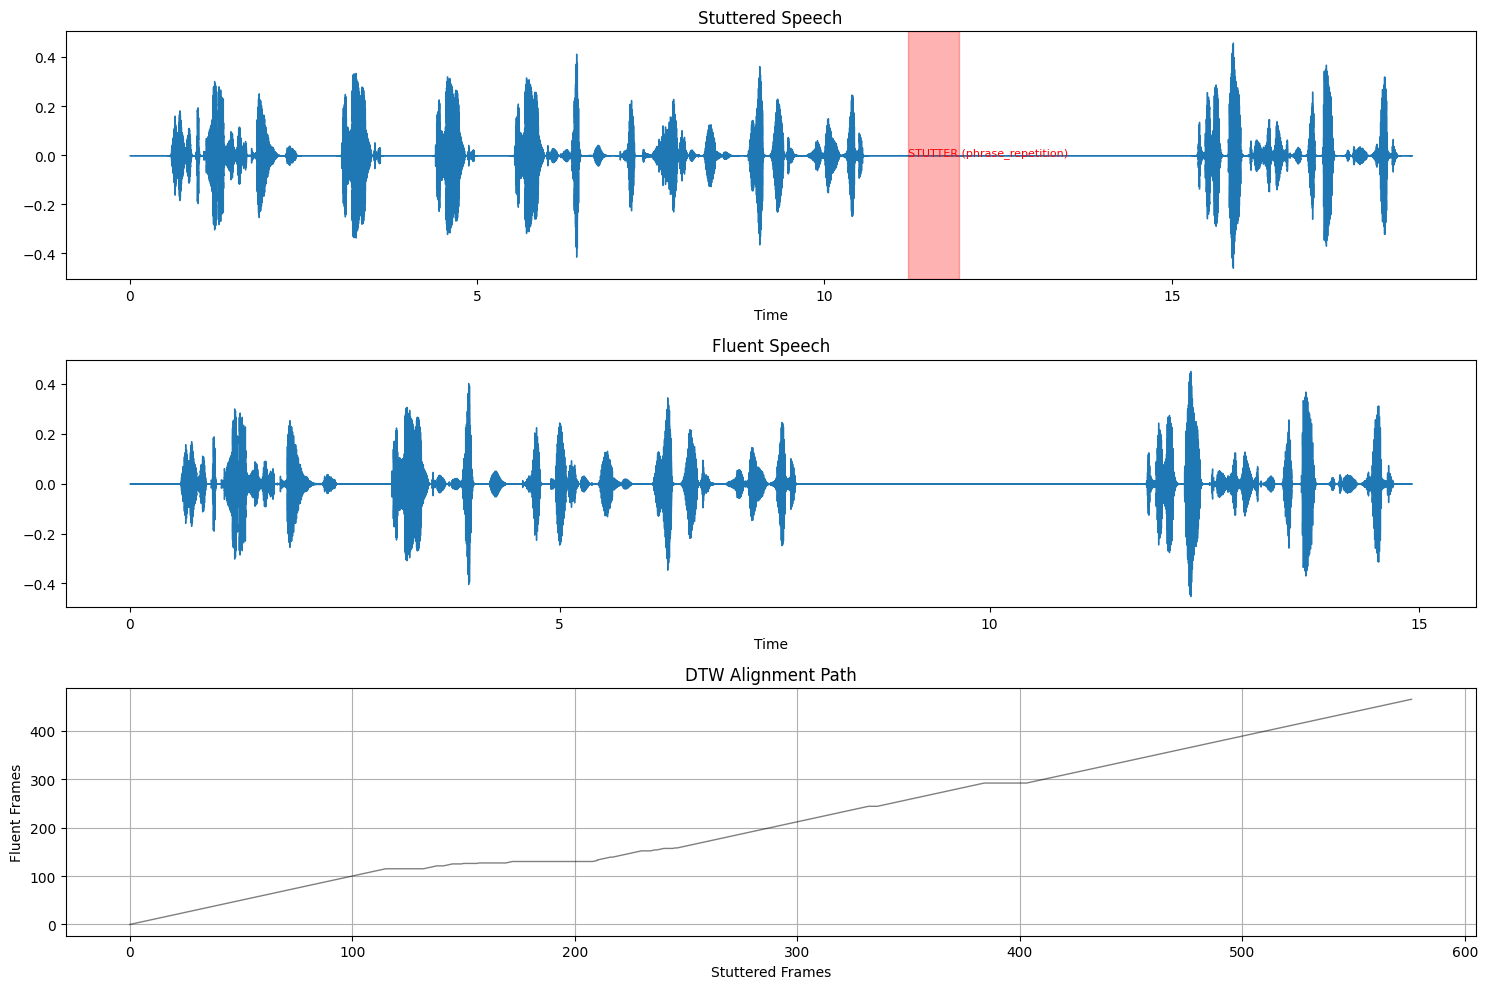

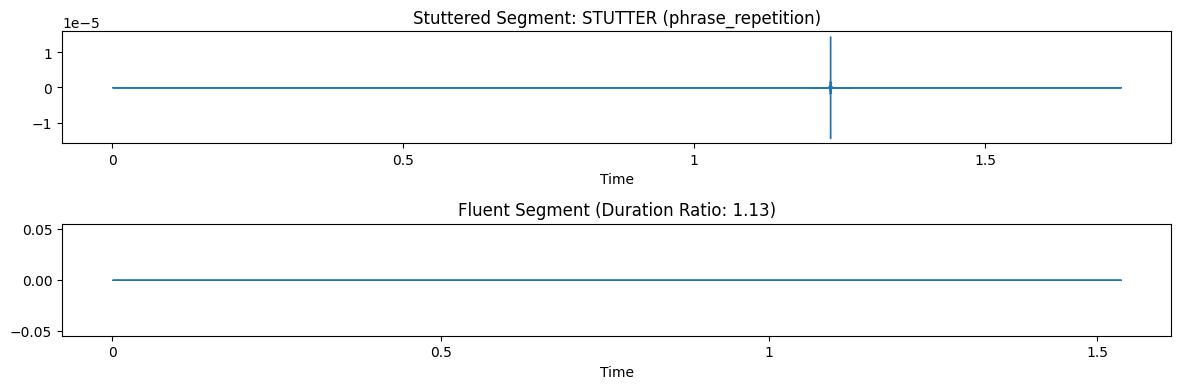

Extracting paired segments...
Found 1 paired segments in this file.
Saving to dataset...
Saved 1 paired segments to dataset.


In [ ]:
# Process a single file first for testing
if len(file_triplets) > 0:
    print("\nTesting with first file triplet...")
    triplet = file_triplets[0]

    # Load audio files
    print(f"Loading audio files...")
    stutter_audio, sr = load_audio(triplet["stuttered"])
    fluent_audio, _ = load_audio(triplet["fluent"])

    # Load annotations
    annotations = None
    if triplet["annotation"]:
        print(f"Loading annotations...")
        annotations = load_annotations(triplet["annotation"])
    else:
        print("No annotation file found. Cannot continue.")

    if stutter_audio is not None and fluent_audio is not None and annotations:
        # Perform DTW alignment
        print("Performing DTW alignment...")
        distance, path = perform_dtw_alignment(stutter_audio, fluent_audio, sr)

        if path is not None:
            # Create time mapping
            print("Creating time mapping...")
            time_mapping = create_time_mapping(path, sr)

            # Visualize for inspection
            print("Visualizing example...")
            visualize_example(stutter_audio, fluent_audio, path, annotations, time_mapping, sr)

            # Extract paired segments
            print("Extracting paired segments...")
            paired_segments = extract_paired_segments(stutter_audio, fluent_audio, annotations, time_mapping, sr)

            if paired_segments:
                print(f"Found {len(paired_segments)} paired segments in this file.")

                # Save to dataset
                print("Saving to dataset...")
                num_saved = save_dataset(paired_segments, OUTPUT_DIR, triplet["speaker_id"], triplet["utterance_id"], sr)

                print(f"Saved {num_saved} paired segments to dataset.")
            else:
                print("No valid paired segments found in this file.")
        else:
            print("DTW alignment failed.")

In [ ]:
# Create counters
total_segments = 0
stutter_types = {}

# Process files
print("Processing all files...")
for i, triplet in enumerate(tqdm(file_triplets)):
    # Skip files without annotation
    if not triplet["annotation"]:
        continue

    # Load audio files
    stutter_audio, sr = load_audio(triplet["stuttered"])
    fluent_audio, _ = load_audio(triplet["fluent"])

    # Skip if audio loading failed
    if stutter_audio is None or fluent_audio is None:
        continue

    # Load annotations
    annotations = load_annotations(triplet["annotation"])

    # Skip if no annotations found
    if not annotations:
        continue

    # Perform DTW alignment
    distance, path = perform_dtw_alignment(stutter_audio, fluent_audio, sr)

    # Skip if alignment failed
    if path is None:
        continue

    # Create time mapping
    time_mapping = create_time_mapping(path, sr)

    # Extract paired segments
    paired_segments = extract_paired_segments(stutter_audio, fluent_audio, annotations, time_mapping, sr)

    # Save to dataset
    num_saved = save_dataset(paired_segments, OUTPUT_DIR, triplet["speaker_id"], triplet["utterance_id"], sr)

    # Update counters
    total_segments += num_saved

    # Update stutter type counts
    for segment in paired_segments:
        stutter_type = segment["stutter_type"]
        stutter_types[stutter_type] = stutter_types.get(stutter_type, 0) + 1

    # Print progress every 10 files
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{len(file_triplets)} files. Total segments: {total_segments}")

# Create metadata file
metadata = {
    "dataset_name": "RepetitionStutterDataset",
    "description": "Dataset of paired stuttered and fluent speech segments focusing on repetition-type stutters",
    "total_segments": total_segments,
    "stutter_type_counts": stutter_types,
    "created_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
}

metadata_path = os.path.join(OUTPUT_DIR, "metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("\nDataset creation complete!")
print(f"Total segments: {total_segments}")
print(f"Stutter type counts: {stutter_types}")
print(f"Metadata saved to: {metadata_path}")

Processing all files...


  0%|          | 0/2756 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
2  leopard  2.698413            3.098413  0
Performing DTW alignment: (544, 13) frames to (454, 13) frames
DTW distance: 18644.43500720991
CSV sample from 4830-25898-0055.csv:
      and  0.0  0.4  0
0    with  0.4  0.5  0
1       a  0.5  0.6  0
2  shiver  0.6  1.0  0
CSV sample from 4830-25898-0004.csv:
  before  0.1  0.7000000000000001  0
0     he  0.7                 0.8  0
1    had  0.8                 1.1  0
2      a  1.1                 1.1  0
Performing DTW alignment: (494, 13) frames to (454, 13) frames
DTW distance: 14100.890059318966
CSV sample from 4830-25898-0024.csv:
         or  0.30000000000000004  0.7000000000000001  0
0  sometime                  0.7                 1.3  0
1     after                  1.3                 1.4  0
2      this                  1.4                 1.8  0
Performing DTW alignment: (485, 13) frames to (452, 13) frames
DTW distance: 20060.503827073
CSV sample from 4830-25898-0019.csv:
  STUTTER

In [ ]:
# Parameters
test_ratio = 0.1
random_seed = 42

# Set random seed for reproducibility
np.random.seed(random_seed)

# Create train/test directories
train_dir = os.path.join(OUTPUT_DIR, "train")
test_dir = os.path.join(OUTPUT_DIR, "test")

os.makedirs(os.path.join(train_dir, "stuttered"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "fluent"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "annotations"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "stuttered"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "fluent"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "annotations"), exist_ok=True)

# Get all speaker directories
speaker_dirs = []
for subdir in ["stuttered", "fluent", "annotations"]:
    base_dir = os.path.join(OUTPUT_DIR, subdir)
    if os.path.exists(base_dir):
        for speaker_dir in os.listdir(base_dir):
            speaker_path = os.path.join(base_dir, speaker_dir)
            if os.path.isdir(speaker_path) and speaker_dir not in speaker_dirs:
                speaker_dirs.append(speaker_dir)

# Randomly split speakers
num_test_speakers = max(1, int(len(speaker_dirs) * test_ratio))
test_speakers = np.random.choice(speaker_dirs, num_test_speakers, replace=False)
train_speakers = [s for s in speaker_dirs if s not in test_speakers]

print(f"Train speakers: {len(train_speakers)}")
print(f"Test speakers: {len(test_speakers)}")

# Copy files to train/test directories
train_count = 0
test_count = 0

for subdir in ["stuttered", "fluent", "annotations"]:
    for speaker in train_speakers:
        src_dir = os.path.join(OUTPUT_DIR, subdir, speaker)
        dst_dir = os.path.join(train_dir, subdir, speaker)

        if os.path.exists(src_dir):
            if not os.path.exists(dst_dir):
                os.makedirs(dst_dir, exist_ok=True)

            # Copy files
            for file in os.listdir(src_dir):
                src_file = os.path.join(src_dir, file)
                dst_file = os.path.join(dst_dir, file)

                if os.path.isfile(src_file):
                    shutil.copy2(src_file, dst_file)
                    train_count += 1

    for speaker in test_speakers:
        src_dir = os.path.join(OUTPUT_DIR, subdir, speaker)
        dst_dir = os.path.join(test_dir, subdir, speaker)

        if os.path.exists(src_dir):
            if not os.path.exists(dst_dir):
                os.makedirs(dst_dir, exist_ok=True)

            # Copy files
            for file in os.listdir(src_dir):
                src_file = os.path.join(src_dir, file)
                dst_file = os.path.join(dst_dir, file)

                if os.path.isfile(src_file):
                    shutil.copy2(src_file, dst_file)
                    test_count += 1

# Create split metadata
for split_dir, count, speakers in [(train_dir, train_count//3, train_speakers),
                                  (test_dir, test_count//3, test_speakers)]:
    metadata = {
        "split": os.path.basename(split_dir),
        "segment_count": count,
        "speakers": speakers,
    }

    metadata_path = os.path.join(split_dir, "metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

print(f"Train/test split creation complete.")
print(f"Train segments: {train_count//3}")
print(f"Test segments: {test_count//3}")

Train speakers: 67
Test speakers: 7


TypeError: Object of type ndarray is not JSON serializable

Inspecting sample: 4018-103416-0016_000.flac
Speaker: 4018-103416
Annotation: {'segment_id': '4018-103416-0016_000', 'word': 'STUTTER', 'stutter_type': 'word_repetition', 'duration_ratio': 2.4208177894813834, 'stutter_path': 'stuttered/4018-103416/4018-103416-0016_000.flac', 'fluent_path': 'fluent/4018-103416/4018-103416-0016_000.flac'}


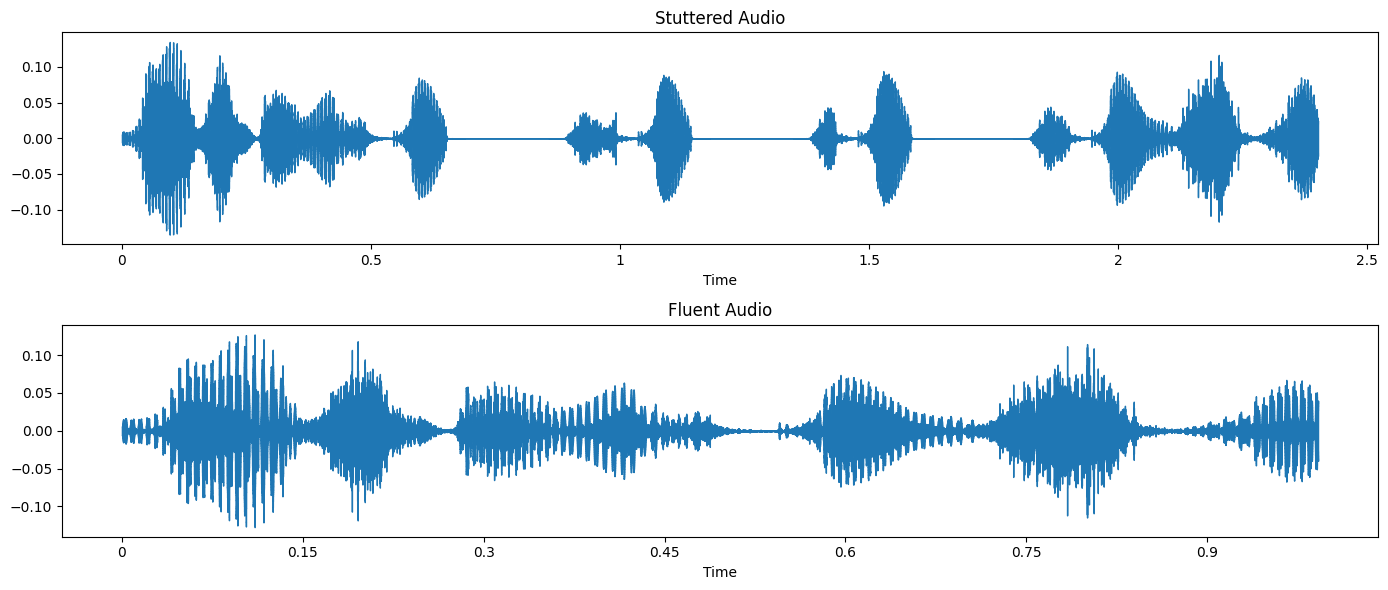

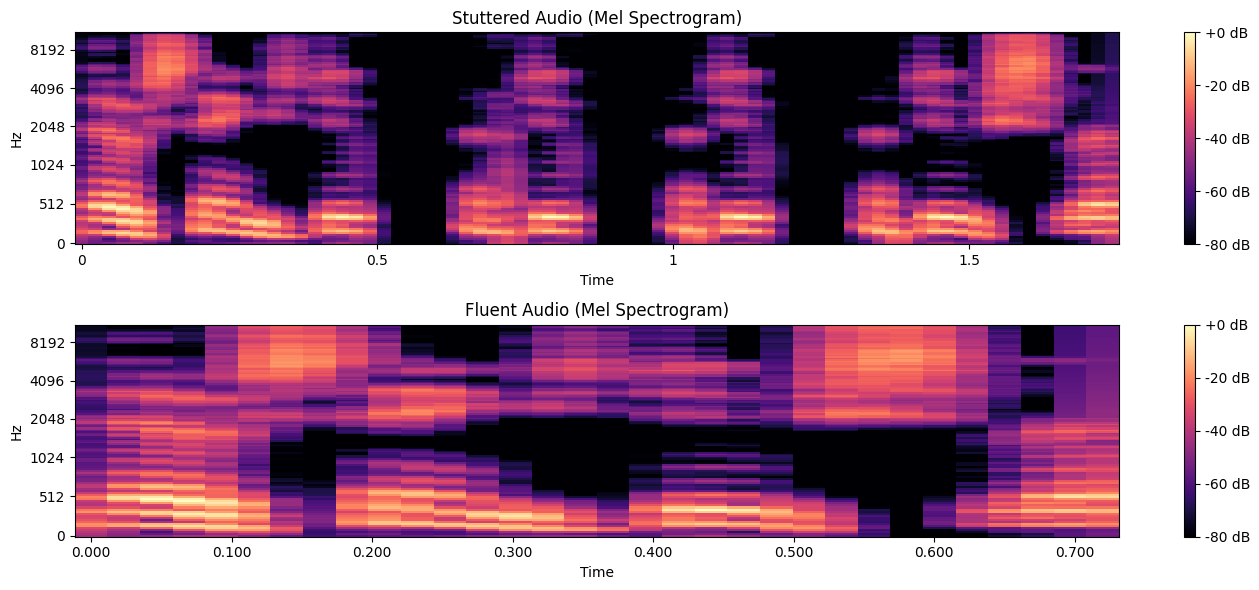

In [ ]:
def inspect_random_sample(dataset_dir):
    # Find all stuttered audio files
    stutter_files = []
    for root, _, files in os.walk(os.path.join(dataset_dir, "stuttered")):
        for file in files:
            if file.endswith(".flac"):
                stutter_files.append(os.path.join(root, file))

    if not stutter_files:
        print("No samples found in dataset.")
        return

    # Pick a random file
    sample_path = np.random.choice(stutter_files)

    # Get corresponding fluent file
    rel_path = os.path.relpath(sample_path, os.path.join(dataset_dir, "stuttered"))
    fluent_path = os.path.join(dataset_dir, "fluent", rel_path)

    # Load audio
    stutter_audio, sr = librosa.load(sample_path, sr=16000)
    fluent_audio, _ = librosa.load(fluent_path, sr=16000)

    # Find annotation
    parts = os.path.normpath(rel_path).split(os.sep)
    speaker_id = parts[0]
    segment_id = os.path.splitext(parts[1])[0]
    utterance_id = "_".join(segment_id.split("_")[:-1])

    annotation_path = os.path.join(dataset_dir, "annotations", speaker_id, f"{utterance_id}.json")

    annotation_info = "Not found"
    if os.path.exists(annotation_path):
        with open(annotation_path, 'r') as f:
            annotations = json.load(f)
            for a in annotations:
                if a["segment_id"] == segment_id:
                    annotation_info = a
                    break

    # Display
    print(f"Inspecting sample: {os.path.basename(sample_path)}")
    print(f"Speaker: {speaker_id}")
    print(f"Annotation: {annotation_info}")

    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(stutter_audio, sr=sr)
    plt.title("Stuttered Audio")

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(fluent_audio, sr=sr)
    plt.title("Fluent Audio")

    plt.tight_layout()
    plt.show()

    # Show spectrograms
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    S_stutter = librosa.feature.melspectrogram(y=stutter_audio, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S_stutter, ref=np.max), y_axis='mel', x_axis='time')
    plt.title("Stuttered Audio (Mel Spectrogram)")
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 1, 2)
    S_fluent = librosa.feature.melspectrogram(y=fluent_audio, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S_fluent, ref=np.max), y_axis='mel', x_axis='time')
    plt.title("Fluent Audio (Mel Spectrogram)")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

inspect_random_sample("/content/drive/MyDrive/pp2/repetition_dataset")

Inspecting sample: 2952-410-0003_001.flac
Speaker: 2952-410
Annotation: {'segment_id': '2952-410-0003_001', 'word': 'STUTTER', 'stutter_type': 'phrase_repetition', 'duration_ratio': 1.7991337159863965, 'stutter_path': 'stuttered/2952-410/2952-410-0003_001.flac', 'fluent_path': 'fluent/2952-410/2952-410-0003_001.flac'}


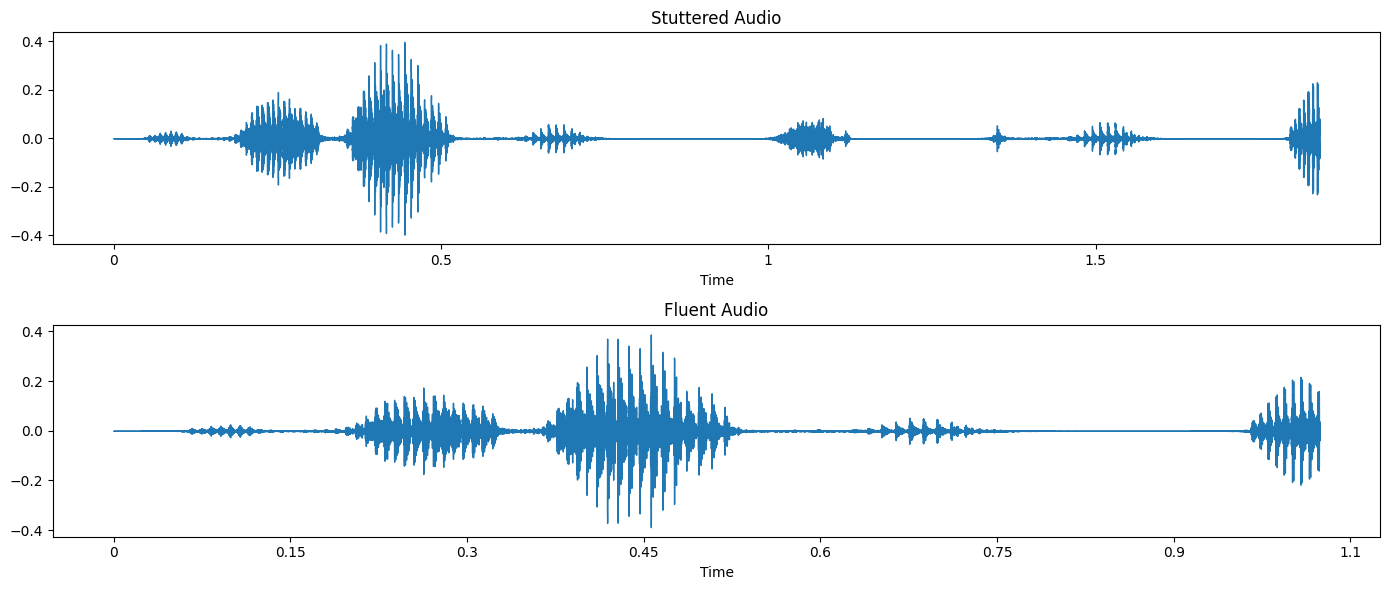

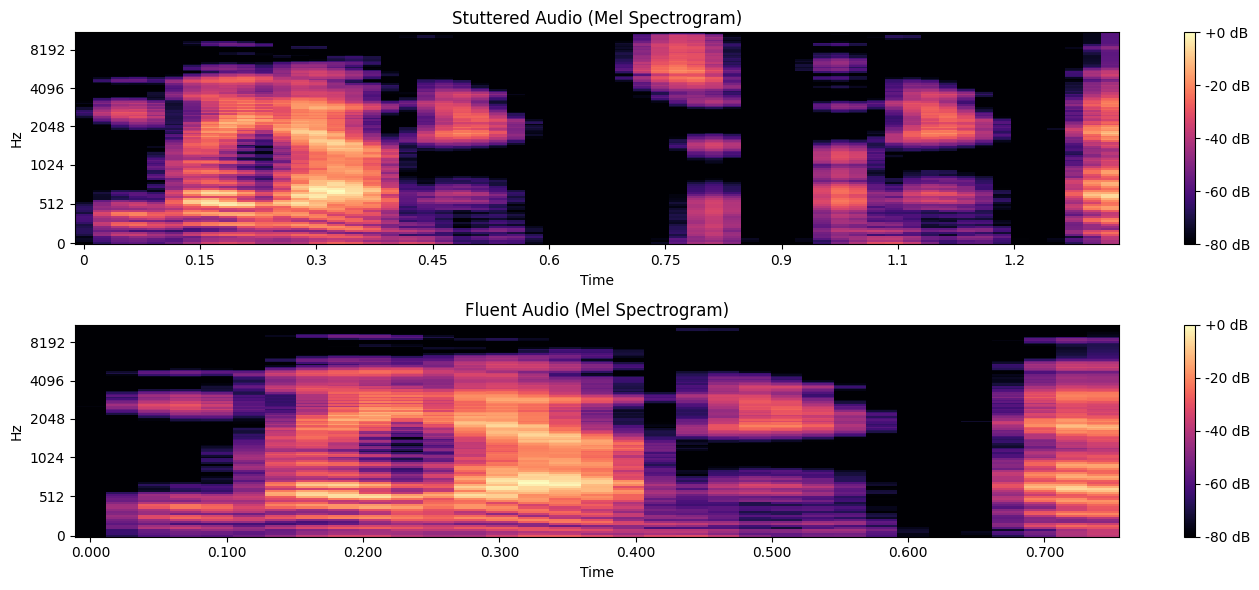

In [ ]:
def inspect_random_sample(dataset_dir):
    # Find all stuttered audio files
    stutter_files = []
    for root, _, files in os.walk(os.path.join(dataset_dir, "stuttered")):
        for file in files:
            if file.endswith(".flac"):
                stutter_files.append(os.path.join(root, file))

    if not stutter_files:
        print("No samples found in dataset.")
        return

    # Pick a random file
    sample_path = np.random.choice(stutter_files)

    # Get corresponding fluent file
    rel_path = os.path.relpath(sample_path, os.path.join(dataset_dir, "stuttered"))
    fluent_path = os.path.join(dataset_dir, "fluent", rel_path)

    # Load audio
    stutter_audio, sr = librosa.load(sample_path, sr=16000)
    fluent_audio, _ = librosa.load(fluent_path, sr=16000)

    # Find annotation
    parts = os.path.normpath(rel_path).split(os.sep)
    speaker_id = parts[0]
    segment_id = os.path.splitext(parts[1])[0]
    utterance_id = "_".join(segment_id.split("_")[:-1])

    annotation_path = os.path.join(dataset_dir, "annotations", speaker_id, f"{utterance_id}.json")

    annotation_info = "Not found"
    if os.path.exists(annotation_path):
        with open(annotation_path, 'r') as f:
            annotations = json.load(f)
            for a in annotations:
                if a["segment_id"] == segment_id:
                    annotation_info = a
                    break

    # Display
    print(f"Inspecting sample: {os.path.basename(sample_path)}")
    print(f"Speaker: {speaker_id}")
    print(f"Annotation: {annotation_info}")

    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(stutter_audio, sr=sr)
    plt.title("Stuttered Audio")

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(fluent_audio, sr=sr)
    plt.title("Fluent Audio")

    plt.tight_layout()
    plt.show()

    # Show spectrograms
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    S_stutter = librosa.feature.melspectrogram(y=stutter_audio, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S_stutter, ref=np.max), y_axis='mel', x_axis='time')
    plt.title("Stuttered Audio (Mel Spectrogram)")
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 1, 2)
    S_fluent = librosa.feature.melspectrogram(y=fluent_audio, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S_fluent, ref=np.max), y_axis='mel', x_axis='time')
    plt.title("Fluent Audio (Mel Spectrogram)")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

inspect_random_sample(OUTPUT_DIR)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def build_seq2seq_model(input_dim=80, max_seq_length=None):
    # Encoder
    encoder_inputs = Input(shape=(max_seq_length, input_dim))

    # Convolutional feature extraction
    x = Conv1D(128, 3, padding='same', activation='relu')(encoder_inputs)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Bidirectional LSTM for temporal modeling
    encoder = Bidirectional(LSTM(256, return_sequences=True))(x)
    encoder = Bidirectional(LSTM(256, return_sequences=True))(encoder)

    # Decoder with attention
    decoder = LSTM(512, return_sequences=True)(encoder)

    # Self-attention mechanism
    attention = Attention()([decoder, decoder])

    # Output projection
    outputs = TimeDistributed(Dense(input_dim))(attention)

    model = Model(inputs=encoder_inputs, outputs=outputs)
    return model

In [ ]:
def create_dataset(data_dir, split='train', feature_type='mfcc', batch_size=32, max_length=None):
    stuttered_dir = os.path.join(data_dir, split, 'stuttered')
    fluent_dir = os.path.join(data_dir, split, 'fluent')

    stuttered_files = []
    fluent_files = []

    # Collect paired files
    for root, _, files in os.walk(stuttered_dir):
        for file in files:
            if file.endswith('.flac'):
                stutter_path = os.path.join(root, file)
                rel_path = os.path.relpath(os.path.dirname(stutter_path), stuttered_dir)
                fluent_path = os.path.join(fluent_dir, rel_path, file)

                if os.path.exists(fluent_path):
                    stuttered_files.append(stutter_path)
                    fluent_files.append(fluent_path)

    print(f"Found {len(stuttered_files)} paired files for {split} set")

    # Determine max_length if not provided
    if max_length is None:
        # Sample a few files to determine a reasonable max length
        max_seq_len = 0
        for i, (stutter_path, fluent_path) in enumerate(zip(stuttered_files[:100], fluent_files[:100])):
            stutter_audio, sr = librosa.load(stutter_path, sr=16000)
            stutter_features = librosa.feature.melspectrogram(y=stutter_audio, sr=sr, n_mels=80).T
            max_seq_len = max(max_seq_len, stutter_features.shape[0])
            if i >= 20:  # Sample just a few for speed
                break
        max_length = min(1000, max_seq_len)  # Limit to reasonable size
        print(f"Using max_length={max_length} frames")

    input_dim = 80 if feature_type == 'melspec' else 40

    # Create TensorFlow dataset
    def generator():
        for stutter_path, fluent_path in zip(stuttered_files, fluent_files):
            # Load audio
            stutter_audio, sr = librosa.load(stutter_path, sr=16000)
            fluent_audio, _ = librosa.load(fluent_path, sr=16000)

            # Extract features
            if feature_type == 'mfcc':
                stutter_features = librosa.feature.mfcc(y=stutter_audio, sr=sr, n_mfcc=40).T
                fluent_features = librosa.feature.mfcc(y=fluent_audio, sr=sr, n_mfcc=40).T
            elif feature_type == 'melspec':
                stutter_features = librosa.feature.melspectrogram(y=stutter_audio, sr=sr, n_mels=80).T
                fluent_features = librosa.feature.melspectrogram(y=fluent_audio, sr=sr, n_mels=80).T
                # Convert to log scale
                stutter_features = librosa.power_to_db(stutter_features)
                fluent_features = librosa.power_to_db(fluent_features)

            # Normalize features
            stutter_features = (stutter_features - stutter_features.mean()) / (stutter_features.std() + 1e-8)
            fluent_features = (fluent_features - fluent_features.mean()) / (fluent_features.std() + 1e-8)

            # Pad or truncate to a fixed length
            if stutter_features.shape[0] > max_length:
                stutter_features = stutter_features[:max_length]
            else:
                pad_length = max_length - stutter_features.shape[0]
                stutter_features = np.pad(stutter_features, ((0, pad_length), (0, 0)))

            if fluent_features.shape[0] > max_length:
                fluent_features = fluent_features[:max_length]
            else:
                pad_length = max_length - fluent_features.shape[0]
                fluent_features = np.pad(fluent_features, ((0, pad_length), (0, 0)))

            yield stutter_features, fluent_features

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(max_length, input_dim), dtype=tf.float32),
            tf.TensorSpec(shape=(max_length, input_dim), dtype=tf.float32)
        )
    )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset, max_length

In [ ]:
def train_model(model, train_dataset, val_dataset, epochs=15):
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Define loss function (MSE or custom loss)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Early stopping
    best_val_loss = float('inf')
    patience = 10
    wait = 0

    for epoch in range(epochs):
        # Reset metrics
        train_loss_values = []
        val_loss_values = []

        # Training
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss_values.append(float(loss))

        # Validation
        for x_batch, y_batch in val_dataset:
            predictions = model(x_batch, training=False)
            loss = loss_fn(y_batch, predictions)
            val_loss_values.append(float(loss))

        # Calculate average losses
        avg_train_loss = sum(train_loss_values) / len(train_loss_values) if train_loss_values else 0
        avg_val_loss = sum(val_loss_values) / len(val_loss_values) if val_loss_values else 0

        # Print metrics
        print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0
            # Save model
            model.save_weights('best_model.weights.h5')
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best weights
    model.load_weights('best_model.weights.h5')
    return model

In [ ]:
def main():
    # Set paths
    data_dir = "/content/drive/MyDrive/pp2/repetition_dataset"

    # Parameters
    feature_type = 'melspec'  # 'mfcc' or 'melspec'
    input_dim = 80 if feature_type == 'melspec' else 40
    batch_size = 16
    epochs = 25

    # Create datasets - calculate max_length from training set first
    train_dataset, max_length = create_dataset(data_dir, 'train', feature_type, batch_size)
    # Then use the same max_length for validation set
    val_dataset, _ = create_dataset(data_dir, 'test', feature_type, batch_size, max_length)

    # Build model
    model = build_seq2seq_model(input_dim=input_dim, max_seq_length=max_length)

    # Print model summary
    model.summary()

    # Train model
    trained_model = train_model(model, train_dataset, val_dataset, epochs=epochs)

    # Save final model
    trained_model.save('/content/drive/MyDrive/pp2/repetition_removal_model.keras')

    print("Training completed!")

if __name__ == "__main__":
    main()

Found 2718 paired files for train set
Using max_length=91 frames
Found 230 paired files for test set


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 91, 80)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 91, 128)        │         30,848 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 91, 128)        │            512 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 91, 128)        │         49,280 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 91, 128)        │            512 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 91, 512)        │        788,480 │ batch_normalization_3… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 91, 512)        │      1,574,912 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 91, 512)        │      2,099,200 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 91, 512)        │              0 │ lstm_5[0][0],          │
│                           │                        │                │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 91, 80)         │         41,040 │ attention_1[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,584,784 (17.49 MB)

 Trainable params: 4,584,272 (17.49 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1, Loss: 0.2074, Val Loss: 0.1719
Epoch 2, Loss: 0.1612, Val Loss: 0.1594
Epoch 3, Loss: 0.1463, Val Loss: 0.1493
Epoch 4, Loss: 0.1316, Val Loss: 0.1358
Epoch 5, Loss: 0.1216, Val Loss: 0.1326
Epoch 6, Loss: 0.1149, Val Loss: 0.1256
Epoch 7, Loss: 0.1086, Val Loss: 0.1238
Epoch 8, Loss: 0.1019, Val Loss: 0.1140
Epoch 9, Loss: 0.0968, Val Loss: 0.1185
Epoch 10, Loss: 0.0909, Val Loss: 0.1386
Epoch 11, Loss: 0.0883, Val Loss: 0.1253
Epoch 12, Loss: 0.0835, Val Loss: 0.1260
Epoch 13, Loss: 0.0808, Val Loss: 0.1199
Epoch 14, Loss: 0.0760, Val Loss: 0.1147
Epoch 15, Loss: 0.0741, Val Loss: 0.1133
Epoch 16, Loss: 0.0749, Val Loss: 0.1163
Epoch 17, Loss: 0.0715, Val Loss: 0.1190
Epoch 18, Loss: 0.0666, Val Loss: 0.1154
Epoch 19, Loss: 0.0627, Val Loss: 0.1124
Epoch 20, Loss: 0.0607, Val Loss: 0.1138
Epoch 21, Loss: 0.0572, Val Loss: 0.1145
Epoch 22, Loss: 0.0543, Val Loss: 0.1126
Epoch 23, Loss: 0.0520, Val Loss: 0.1123
Epoch 24, Loss: 0.0508, Val Loss: 0.1130
Epoch 25, Loss: 0.0504, V

In [ ]:
# def main():
#     # Set paths
#     data_dir = "/content/drive/MyDrive/pp2/repetition_dataset"

#     # Parameters
#     feature_type = 'melspec'  # 'mfcc' or 'melspec'
#     input_dim = 80 if feature_type == 'melspec' else 40
#     batch_size = 16
#     epochs = 25

#     # Create datasets - calculate max_length from training set first
#     train_dataset, max_length = create_dataset(data_dir, 'train', feature_type, batch_size)
#     # Then use the same max_length for validation set
#     val_dataset, _ = create_dataset(data_dir, 'test', feature_type, batch_size, max_length)

#     # Build model
#     model = build_seq2seq_model(input_dim=input_dim, max_seq_length=max_length)

#     # Print model summary
#     model.summary()

#     # Train model
#     trained_model = train_model(model, train_dataset, val_dataset, epochs=epochs)

#     # Save final model
#     trained_model.save('/content/drive/MyDrive/pp2/repetition_removal_model.keras')

#     print("Training completed!")

# if __name__ == "__main__":
#     main()

Found 2718 paired files for train set
Using max_length=91 frames
Found 230 paired files for test set


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 91, 80)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 91, 128)        │         30,848 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 91, 128)        │            512 │ conv1d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 91, 128)        │         49,280 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 91, 128)        │            512 │ conv1d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_8           │ (None, 91, 512)        │        788,480 │ batch_normalization_9… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, 91, 512)        │      1,574,912 │ bidirectional_8[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 91, 512)        │      2,099,200 │ bidirectional_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_4 (Attention)   │ (None, 91, 512)        │              0 │ lstm_14[0][0],         │
│                           │                        │                │ lstm_14[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 91, 80)         │         41,040 │ attention_4[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,584,784 (17.49 MB)

 Trainable params: 4,584,272 (17.49 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1, Loss: 0.2058, Val Loss: 0.1720
Epoch 2, Loss: 0.1603, Val Loss: 0.1591
Epoch 3, Loss: 0.1419, Val Loss: 0.1442
Epoch 4, Loss: 0.1292, Val Loss: 0.1474
Epoch 5, Loss: 0.1220, Val Loss: 0.1315
Epoch 6, Loss: 0.1133, Val Loss: 0.1274
Epoch 7, Loss: 0.1080, Val Loss: 0.1171
Epoch 8, Loss: 0.1002, Val Loss: 0.1187
Epoch 9, Loss: 0.0970, Val Loss: 0.1343
Epoch 10, Loss: 0.0943, Val Loss: 0.1259
Epoch 11, Loss: 0.0882, Val Loss: 0.1214
Epoch 12, Loss: 0.0828, Val Loss: 0.1148
Epoch 13, Loss: 0.0800, Val Loss: 0.1140
Epoch 14, Loss: 0.0756, Val Loss: 0.1119
Epoch 15, Loss: 0.0705, Val Loss: 0.1132
Epoch 16, Loss: 0.0675, Val Loss: 0.1148
Epoch 17, Loss: 0.0654, Val Loss: 0.1157
Epoch 18, Loss: 0.0637, Val Loss: 0.1179
Epoch 19, Loss: 0.0637, Val Loss: 0.1146
Epoch 20, Loss: 0.0588, Val Loss: 0.1161
Epoch 21, Loss: 0.0551, Val Loss: 0.1254
Epoch 22, Loss: 0.0536, Val Loss: 0.1133
Epoch 23, Loss: 0.0527, Val Loss: 0.1156


Epoch 24, Loss: 0.0513, Val Loss: 0.1199
Early stopping at epoch 24
Training completed!


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


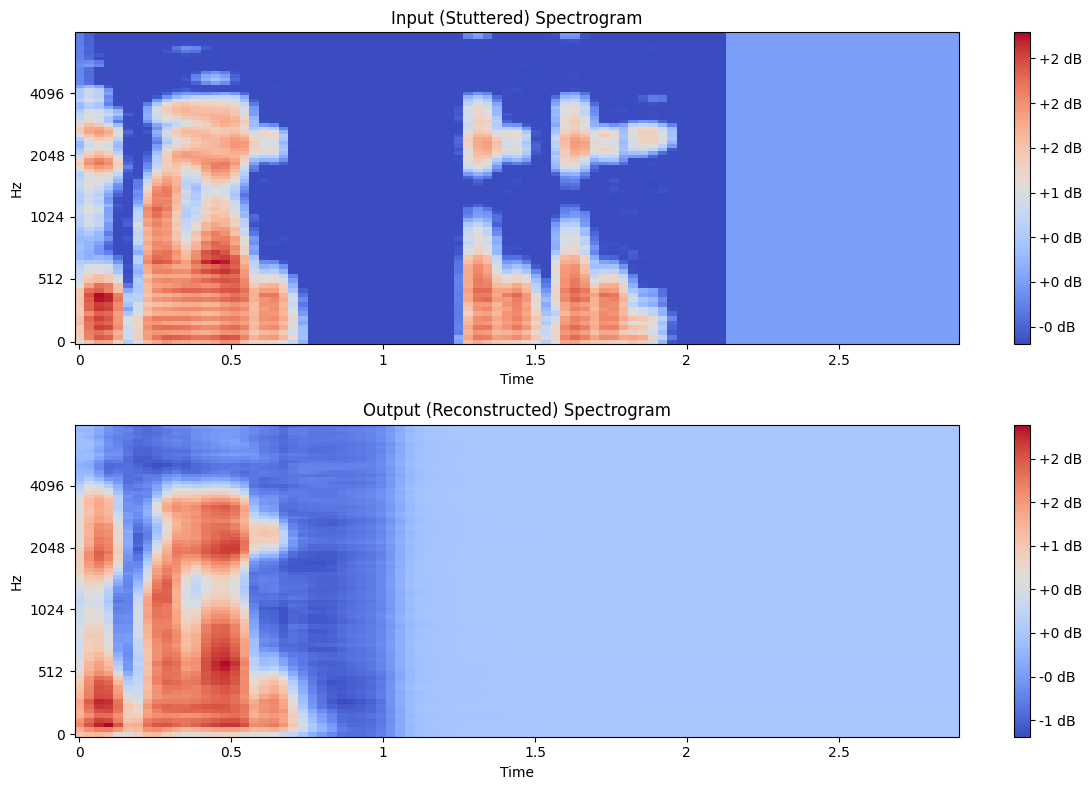

Original Audio:


Reconstructed Audio (after stutter removal):


In [ ]:
def test_inference(model, audio_path):
    # Load audio
    audio, sr = librosa.load(audio_path, sr=16000)

    # Extract features (same as in training)
    features = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80).T
    features = librosa.power_to_db(features)
    features = (features - features.mean()) / (features.std() + 1e-8)

    # Pad/truncate to match the max_length used in training
    if features.shape[0] > max_length:
        features = features[:max_length]
    else:
        pad_length = max_length - features.shape[0]
        features = np.pad(features, ((0, pad_length), (0, 0)))

    # Add batch dimension
    features = np.expand_dims(features, axis=0)

    # Run inference
    output_features = model.predict(features)

    # Remove batch dimension
    output_features = output_features[0]

    # If padded, remove padding
    output_features = output_features[:features.shape[1]]

    # Visualize input and output
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(features[0].T, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Input (Stuttered) Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(output_features.T, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Output (Reconstructed) Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # Optionally convert back to audio
    # Note: This is a simple approach; for better quality you'd use a proper vocoder
    S = librosa.db_to_power(output_features.T)
    y_output = librosa.griffinlim(S)

    # Play the audio
    from IPython.display import Audio
    print("Original Audio:")
    display(Audio(audio, rate=sr))
    print("Reconstructed Audio (after stutter removal):")
    display(Audio(y_output, rate=sr))

    return y_output, sr

# Test on a sample stuttered audio file
max_length=91
model = tf.keras.models.load_model("repetition_removal_model.h5")
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
test_audio_path = "/content/drive/MyDrive/pp2/repetition_dataset/test/stuttered/78-368/78-368-0039_000.flac"
reconstructed_audio, sr = test_inference(model, test_audio_path)

In [ ]:
!pip install numpy scipy librosa unidecode inflect
!apt-get update
!apt-get install -y libsndfile1 wget

!wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/heteronyms-052722 -qO heteronyms
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/cmudict-0.7b_nv22.08 -qO cmudict-0.7b
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

# Load FastPitch model
fastpitch, generator_train_setup = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_fastpitch')

# Load HiFi-GAN model
hifigan, vocoder_train_setup, denoiser = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_hifigan')

CHECKPOINT_SPECIFIC_ARGS = [
    'sampling_rate', 'hop_length', 'win_length', 'p_arpabet', 'text_cleaners',
    'symbol_set', 'max_wav_value', 'prepend_space_to_text',
    'append_space_to_text']

for k in CHECKPOINT_SPECIFIC_ARGS:
    assert generator_train_setup[k] == vocoder_train_setup[k], f"Mismatch in {k}"



Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


HiFi-GAN: Removing weight norm.


KeyError: 'p_arpabet'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


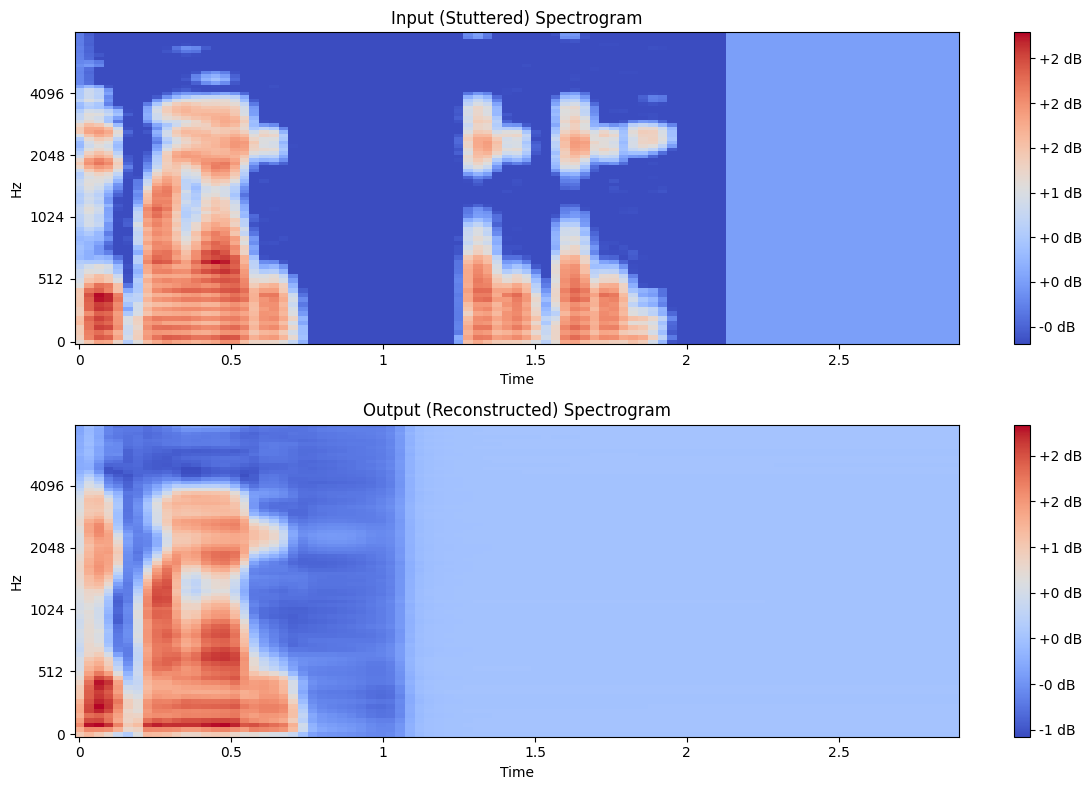

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Original Audio:


Reconstructed Audio (after stutter removal):


In [ ]:
import torch, librosa, numpy as np, matplotlib.pyplot as plt
def test_inference(model, audio_path):
    # Load audio
    audio, sr = librosa.load(audio_path, sr=16000)

    # Extract features (same as in training)
    features = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80).T
    features = librosa.power_to_db(features)
    features = (features - features.mean()) / (features.std() + 1e-8)

    # Pad/truncate to match the max_length used in training
    if features.shape[0] > max_length:
        features = features[:max_length]
    else:
        pad_length = max_length - features.shape[0]
        features = np.pad(features, ((0, pad_length), (0, 0)))

    # Add batch dimension
    features = np.expand_dims(features, axis=0)

    # Run inference
    output_features = model.predict(features)

    # Remove batch dimension
    output_features = output_features[0]

    # If padded, remove padding
    output_features = output_features[:features.shape[1]]

    # Visualize input and output
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(features[0].T, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Input (Stuttered) Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(output_features.T, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Output (Reconstructed) Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()
    return output_features


import torch
import torchaudio
from torchaudio.transforms import GriffinLim, MelSpectrogram, InverseMelScale

def improved_audio_reconstruction(mel_spectrogram, method="hifi-gan"):
    """
    Convert mel spectrogram to audio using better reconstruction methods

    Parameters:
    -----------
    mel_spectrogram : numpy.ndarray
        Mel spectrogram of shape [time, n_mels]
    method : str
        Reconstruction method: "griffin-lim", "hifi-gan", or "waveglow"

    Returns:
    --------
    audio : numpy.ndarray
        Reconstructed audio waveform
    """
    # Convert to torch tensor
    mel_tensor = torch.tensor(mel_spectrogram).T.unsqueeze(0)  # [1, n_mels, time]

    if method == "griffin-lim":
        # Improved Griffin-Lim with more iterations
        inverse_mel = InverseMelScale(
            n_stft=1024,
            n_mels=80,
            sample_rate=16000
        )(mel_tensor)

        griffin_lim = GriffinLim(
            n_fft=1024,
            win_length=400,
            hop_length=160,
            n_iter=60  # More iterations for better quality
        )(inverse_mel)

        return griffin_lim.squeeze().numpy()

    elif method == "hifi-gan":
        # Load pre-trained HiFi-GAN vocoder
        hifi_gan = torch.hub.load('descriptinc/lyra-models', 'hifi-gan')
        hifi_gan.eval()

        with torch.no_grad():
            audio = hifi_gan(mel_tensor)

        return audio.squeeze().numpy()

    elif method == "waveglow":
        # Load pre-trained WaveGlow vocoder
        waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow')
        waveglow = waveglow.remove_weightnorm(waveglow)
        waveglow.eval()

        with torch.no_grad():
            audio = waveglow.infer(mel_tensor)

        return audio.squeeze().numpy()

    else:
        raise ValueError(f"Unknown method: {method}")

# Usage


# Test on a sample stuttered audio file
max_length=91
model = tf.keras.models.load_model("/content/drive/MyDrive/pp2/repetition_removal_model.keras")
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
test_audio_path = "/content/drive/MyDrive/pp2/repetition_dataset/test/stuttered/78-368/78-368-0039_000.flac"
output_feature= test_inference(model, test_audio_path)
reconstructed_audio = improved_audio_reconstruction(output_feature, method="waveglow")

# Play the audio
from IPython.display import Audio
print("Original Audio:")
display(Audio(test_audio_path, rate=16000))
print("Reconstructed Audio (after stutter removal):")
display(Audio(reconstructed_audio, rate=16000))

Found 50 paired test samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


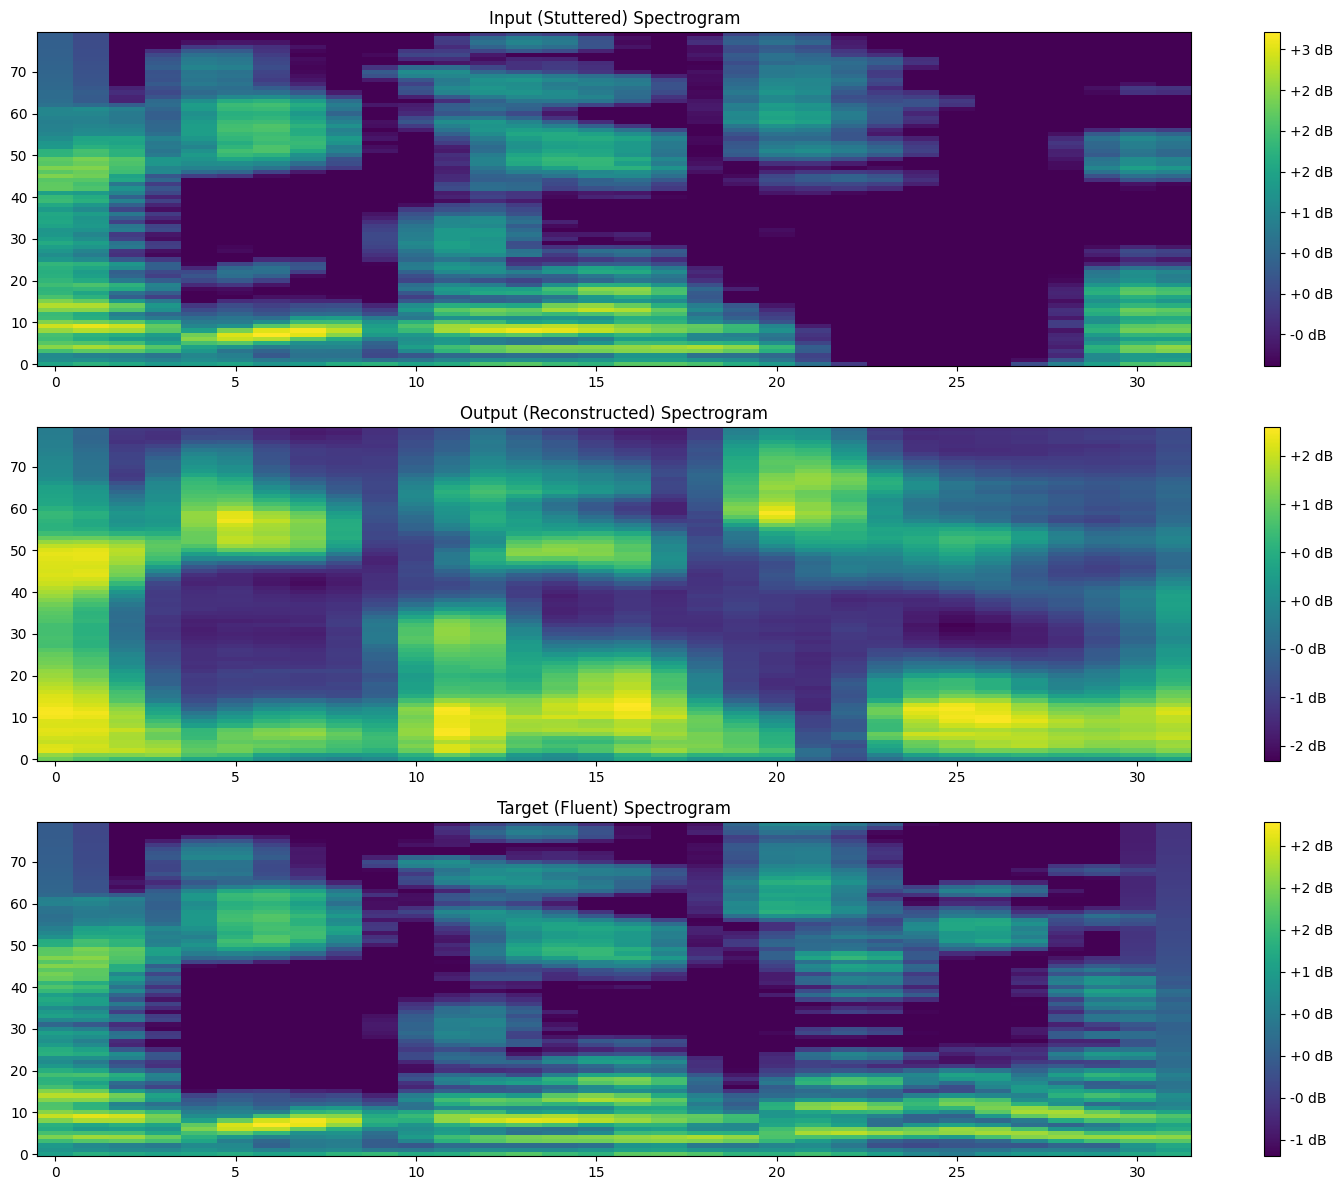

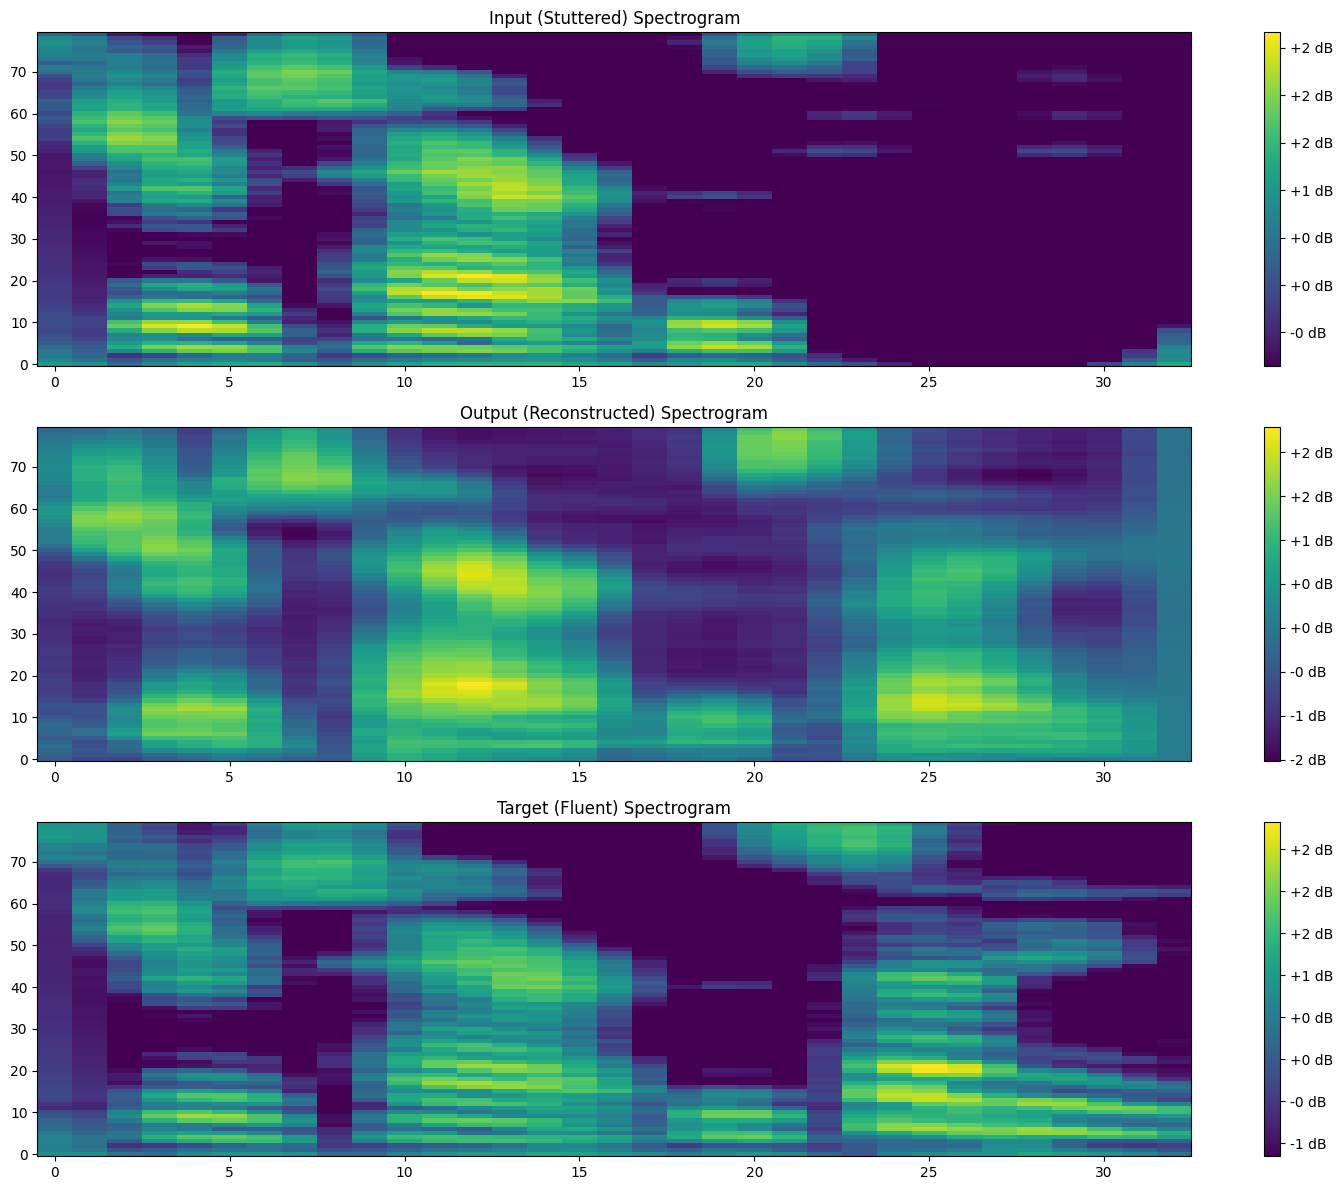

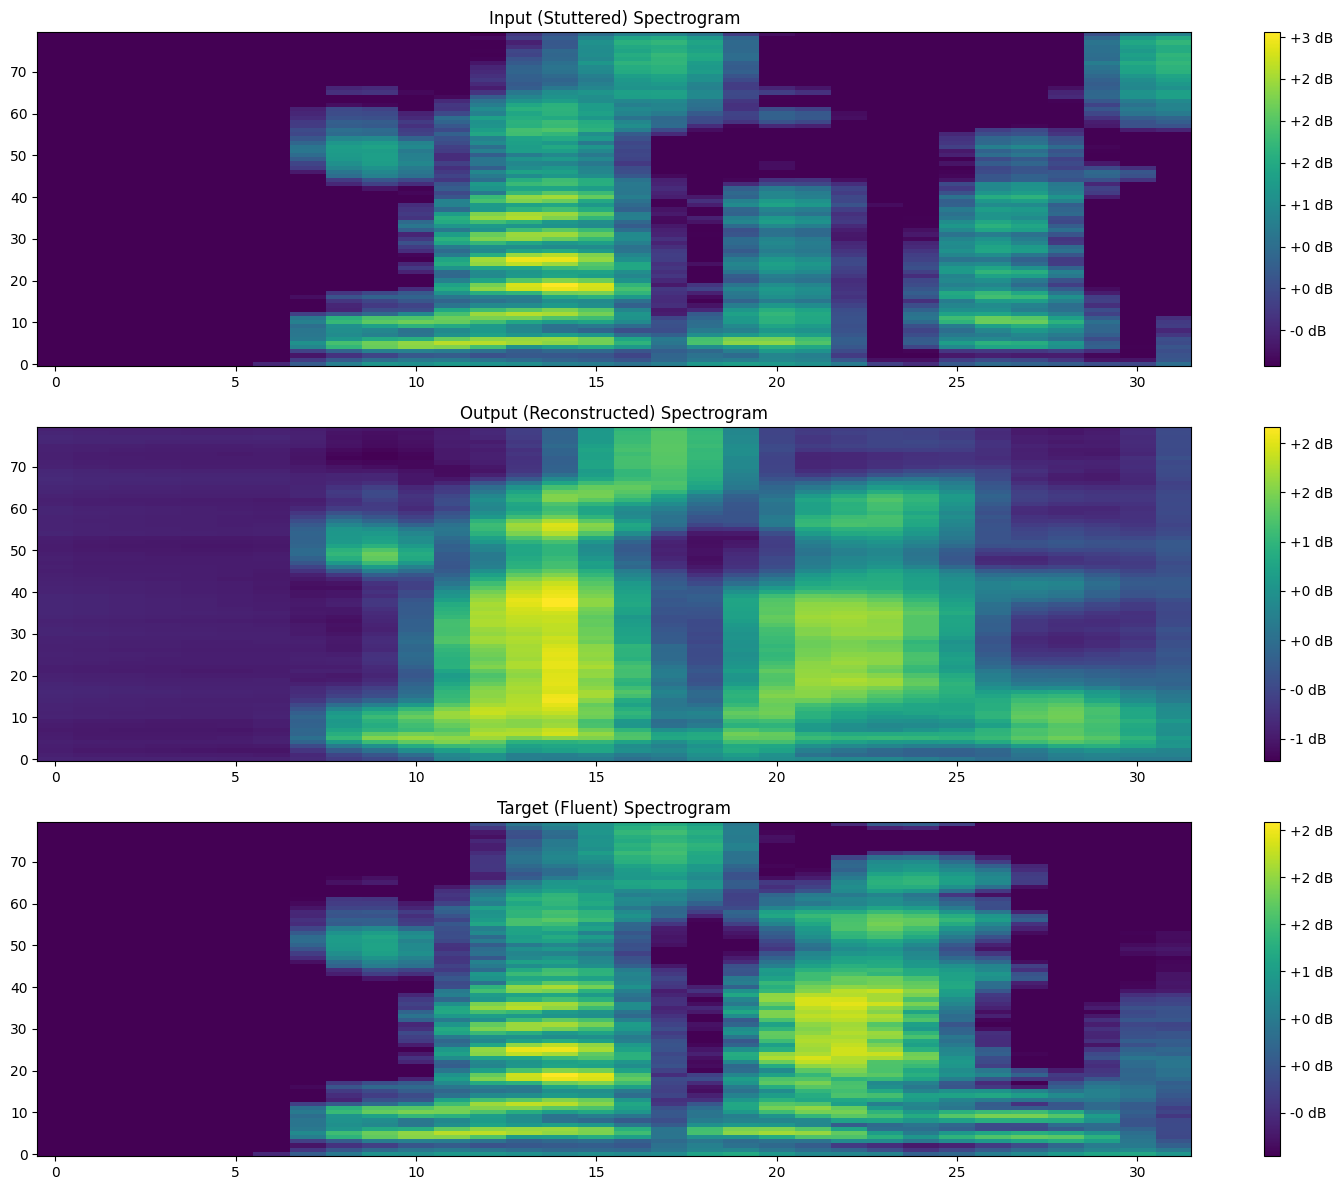

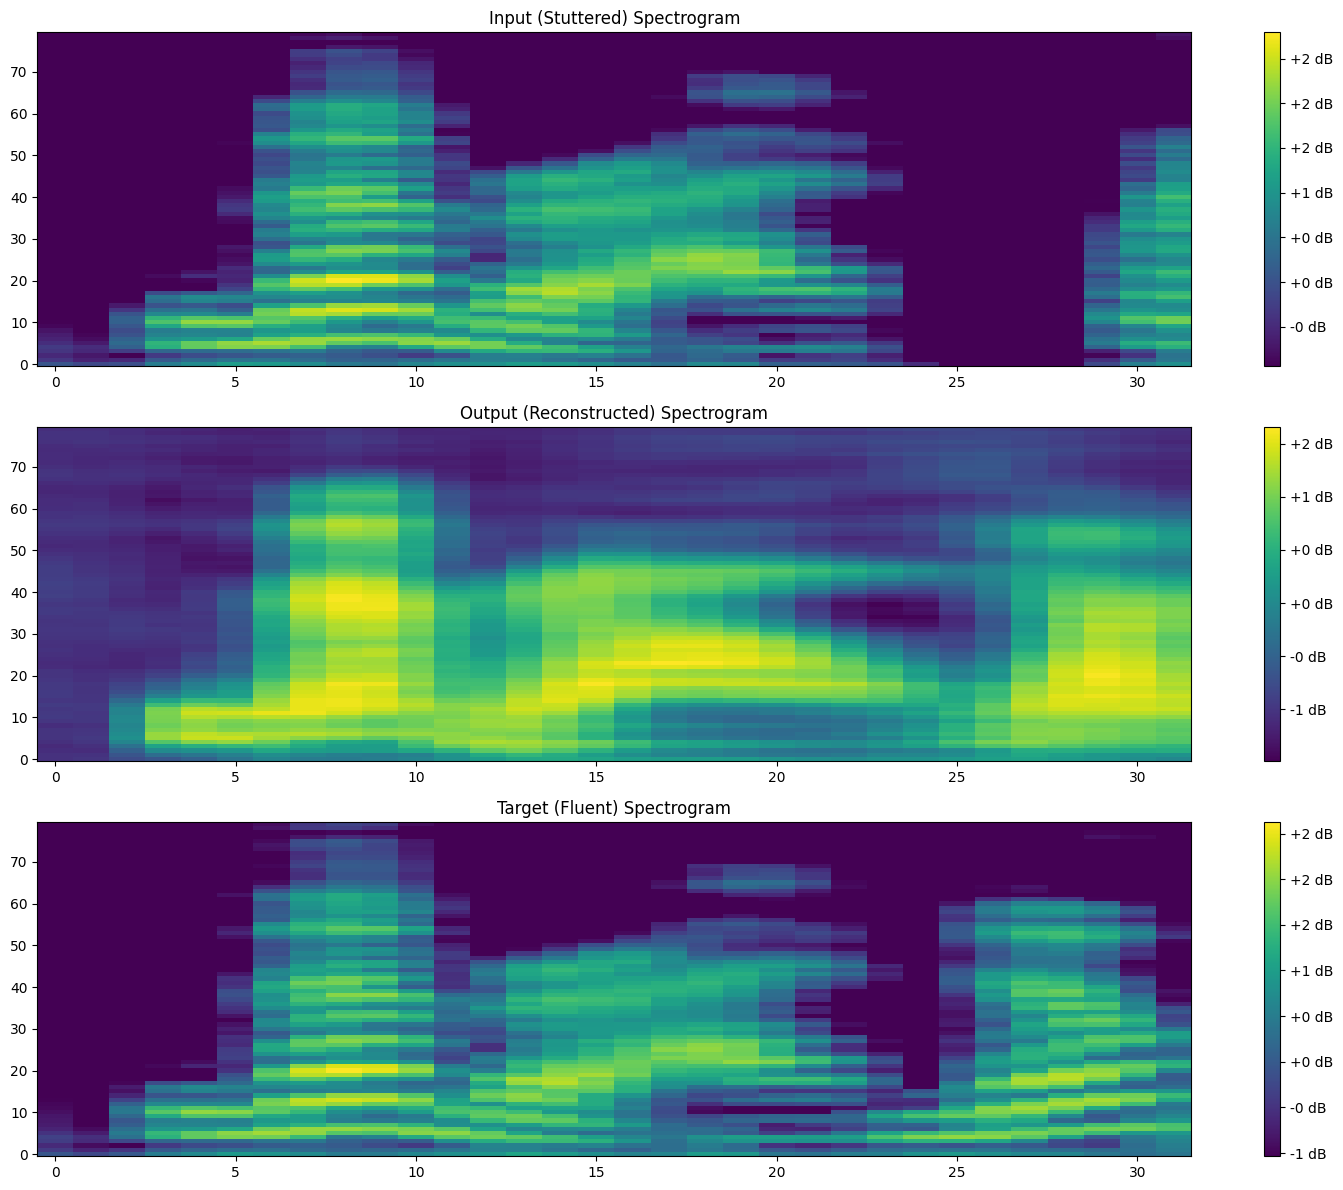

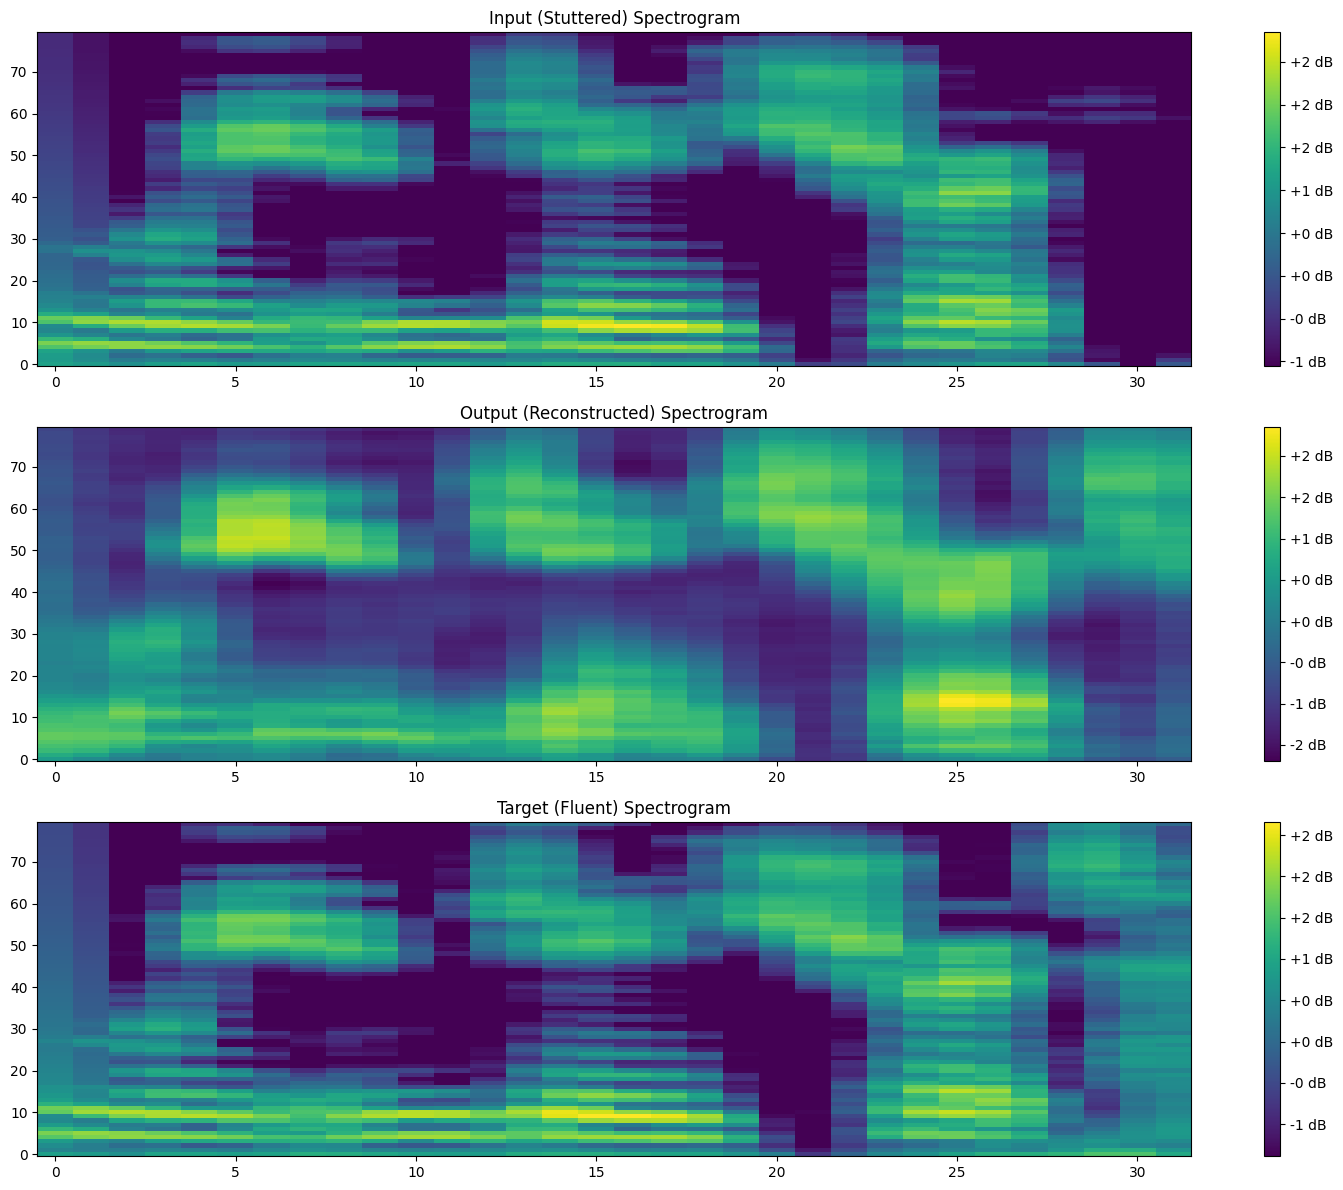

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

=== EVALUATION RESULTS ===
Mean Squared Error: 0.241077
Structural Similarity: 0.4147
Cosine Similarity: 0.8721
Duration Reduction Rate: 1.00


In [ ]:
import matplotlib.pyplot as plt
import librosa, os
import numpy as np
import tensorflow as tf

def evaluate_model_on_test_set(model, test_data_path, max_samples=50):
    """Evaluate your trained model on the test dataset, accounting for potential alignment issues"""
    # Load test dataset - test_data_path should be the main dataset path
    stuttered_dir = os.path.join(test_data_path, "test", "stuttered")
    fluent_dir = os.path.join(test_data_path, "test", "fluent")

    # Find all paired files
    paired_files = []
    for root, _, files in os.walk(stuttered_dir):
        for file in files:
            if file.endswith(".flac"):
                stutter_path = os.path.join(root, file)
                rel_path = os.path.relpath(os.path.dirname(stutter_path), stuttered_dir)
                fluent_path = os.path.join(fluent_dir, rel_path, file)

                if os.path.exists(fluent_path):
                    paired_files.append((stutter_path, fluent_path))

    # Limit the number of samples
    if max_samples and len(paired_files) > max_samples:
        paired_files = paired_files[:max_samples]

    print(f"Found {len(paired_files)} paired test samples")

    # Process each pair
    results = {
        'mse': [],
        'ssim': [],
        'cosine_similarity': [],
        'duration_reduction': []
    }

    from skimage.metrics import structural_similarity
    from scipy.spatial.distance import cosine

    # Process in batches to speed up prediction
    batch_size = 8
    for i in range(0, len(paired_files), batch_size):
        batch_files = paired_files[i:i+batch_size]

        # Load and process files
        batch_stutter_features = []
        batch_fluent_features = []
        stutter_lens = []
        fluent_lens = []

        for stutter_path, fluent_path in batch_files:
            # Load audio
            stutter_audio, sr = librosa.load(stutter_path, sr=16000)
            fluent_audio, _ = librosa.load(fluent_path, sr=16000)

            # Extract features
            stutter_features = librosa.feature.melspectrogram(y=stutter_audio, sr=sr, n_mels=80).T
            stutter_features = librosa.power_to_db(stutter_features)
            stutter_features = (stutter_features - stutter_features.mean()) / (stutter_features.std() + 1e-8)

            fluent_features = librosa.feature.melspectrogram(y=fluent_audio, sr=sr, n_mels=80).T
            fluent_features = librosa.power_to_db(fluent_features)
            fluent_features = (fluent_features - fluent_features.mean()) / (fluent_features.std() + 1e-8)

            # Store original lengths before padding
            stutter_lens.append(stutter_features.shape[0])
            fluent_lens.append(fluent_features.shape[0])

            # Pad features to max_length
            max_length = 91  # Use the same value as in your model training
            if stutter_features.shape[0] > max_length:
                stutter_features = stutter_features[:max_length]
            else:
                pad_length = max_length - stutter_features.shape[0]
                stutter_features = np.pad(stutter_features, ((0, pad_length), (0, 0)))

            if fluent_features.shape[0] > max_length:
                fluent_features = fluent_features[:max_length]
            else:
                pad_length = max_length - fluent_features.shape[0]
                fluent_features = np.pad(fluent_features, ((0, pad_length), (0, 0)))

            batch_stutter_features.append(stutter_features)
            batch_fluent_features.append(fluent_features)

        # Create batch for model input
        stutter_batch = np.array(batch_stutter_features)

        # Get model predictions
        predictions = model.predict(stutter_batch)

        # Calculate metrics for this batch
        for j in range(len(batch_files)):
            stutter_features = batch_stutter_features[j]
            fluent_features = batch_fluent_features[j]
            pred_features = predictions[j]
            stutter_len = stutter_lens[j]
            fluent_len = fluent_lens[j]

            # Trim padding for fair comparison - only compare the actual content length
            # Use the minimum of stutter and fluent lengths to ensure a fair comparison
            compare_len = min(stutter_len, fluent_len, max_length)

            # Trim features to this length
            stutter_features_trimmed = stutter_features[:compare_len]
            pred_features_trimmed = pred_features[:compare_len]
            fluent_features_trimmed = fluent_features[:compare_len]

            # Calculate MSE on trimmed features
            mse = np.mean((pred_features_trimmed - fluent_features_trimmed) ** 2)
            results['mse'].append(mse)

            # Calculate SSIM
            try:
                # SSIM works on 2D images, so we'll calculate it frame by frame
                frame_ssim = []
                for frame_idx in range(compare_len):
                    ssim = structural_similarity(
                        pred_features_trimmed[frame_idx],
                        fluent_features_trimmed[frame_idx],
                        data_range=max(pred_features_trimmed.max(), fluent_features_trimmed.max()) -
                                 min(pred_features_trimmed.min(), fluent_features_trimmed.min())
                    )
                    frame_ssim.append(ssim)

                avg_ssim = np.mean(frame_ssim)
                results['ssim'].append(avg_ssim)
            except Exception as e:
                print(f"Warning: Could not calculate SSIM for sample {i+j}: {e}")

            # Calculate cosine similarity
            flat_pred = pred_features_trimmed.flatten()
            flat_fluent = fluent_features_trimmed.flatten()

            if len(flat_pred) > 0 and len(flat_fluent) > 0:
                cos_sim = 1 - cosine(flat_pred, flat_fluent)
                results['cosine_similarity'].append(cos_sim)

            # Estimate duration reduction by looking at energy patterns
            # This is more robust to alignment issues
            energy_threshold = 0.1 * np.max(fluent_features_trimmed)

            # Count frames with significant energy
            stutter_active_frames = np.sum(np.max(stutter_features_trimmed, axis=1) > energy_threshold)
            pred_active_frames = np.sum(np.max(pred_features_trimmed, axis=1) > energy_threshold)
            fluent_active_frames = np.sum(np.max(fluent_features_trimmed, axis=1) > energy_threshold)

            # Calculate ratios
            if fluent_active_frames > 0:
                stutter_ratio = stutter_active_frames / fluent_active_frames
                pred_ratio = pred_active_frames / fluent_active_frames

                # Only consider cases where stutter is clearly longer
                if stutter_ratio > 1.05:
                    reduction = (stutter_ratio - pred_ratio) / (stutter_ratio - 1)
                    # Clip to reasonable range [0, 1]
                    reduction = max(0, min(1, reduction))
                    results['duration_reduction'].append(reduction)

            # Visualize a few examples
            if i + j < 5:  # First 5 examples
                plt.figure(figsize=(15, 12))

                # Input spectrogram
                plt.subplot(3, 1, 1)
                plt.imshow(stutter_features_trimmed.T, aspect='auto', origin='lower')
                plt.title("Input (Stuttered) Spectrogram")
                plt.colorbar(format='%+2.0f dB')

                # Output spectrogram
                plt.subplot(3, 1, 2)
                plt.imshow(pred_features_trimmed.T, aspect='auto', origin='lower')
                plt.title("Output (Reconstructed) Spectrogram")
                plt.colorbar(format='%+2.0f dB')

                # Target spectrogram
                plt.subplot(3, 1, 3)
                plt.imshow(fluent_features_trimmed.T, aspect='auto', origin='lower')
                plt.title("Target (Fluent) Spectrogram")
                plt.colorbar(format='%+2.0f dB')

                plt.tight_layout()
                plt.savefig(f"example_{i+j+1}.png")
                plt.show()

    # Calculate averages
    avg_results = {}
    for metric in results:
        if results[metric]:  # Check if the list is not empty
            avg_results[metric] = np.mean(results[metric])
        else:
            avg_results[metric] = float('nan')

    # Print results
    print("\n=== EVALUATION RESULTS ===")
    print(f"Mean Squared Error: {avg_results['mse']:.6f}")
    if 'ssim' in avg_results and not np.isnan(avg_results['ssim']):
        print(f"Structural Similarity: {avg_results['ssim']:.4f}")
    print(f"Cosine Similarity: {avg_results['cosine_similarity']:.4f}")
    if 'duration_reduction' in avg_results and not np.isnan(avg_results['duration_reduction']):
        print(f"Duration Reduction Rate: {avg_results['duration_reduction']:.2f}")

    return avg_results, results

# Example usage:

trained_model = tf.keras.models.load_model("/content/drive/MyDrive/pp2/repetition_removal_model.keras")
avg_metrics, detailed_metrics = evaluate_model_on_test_set(
    trained_model,  # Your already loaded model
    "/content/drive/MyDrive/pp2/repetition_dataset"  # Main dataset path
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


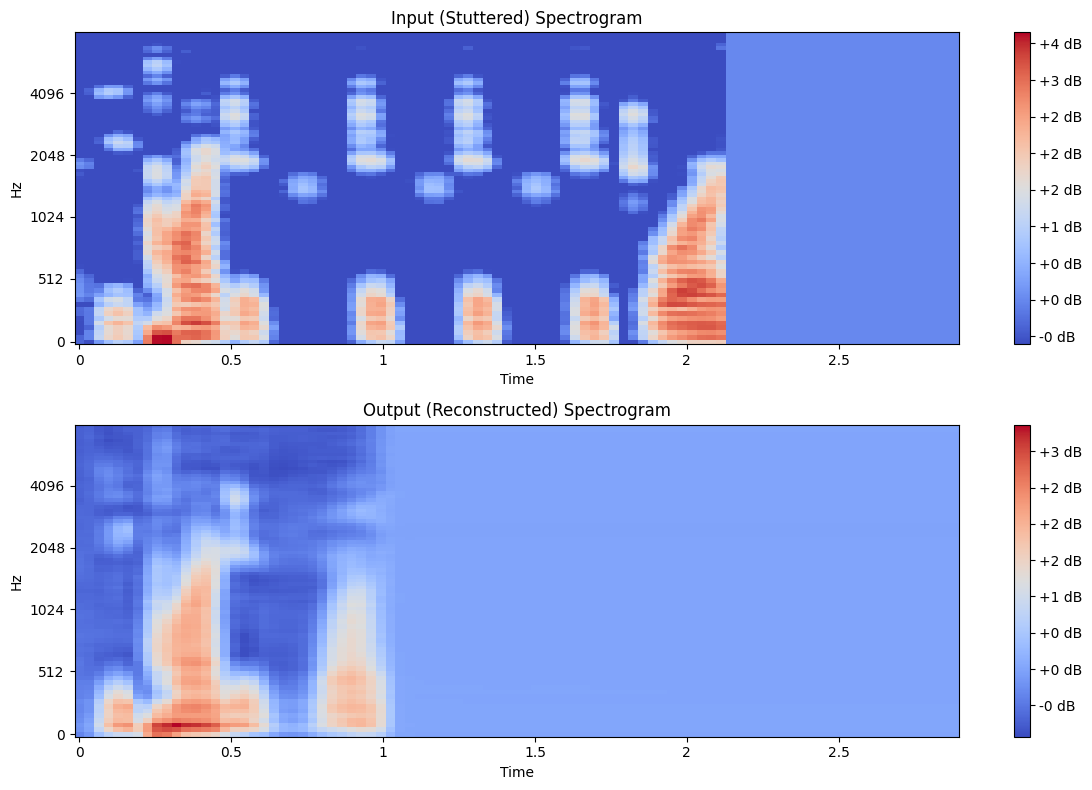

Original Audio:


Reconstructed Audio (after stutter removal):


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa, os
import numpy as np

def test_inference(model, audio_path):
    # Load audio
    audio, sr = librosa.load(audio_path, sr=16000)

    # Extract features (same as in training)
    features = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80).T
    features = librosa.power_to_db(features)
    features = (features - features.mean()) / (features.std() + 1e-8)

    # Pad/truncate to match the max_length used in training
    if features.shape[0] > max_length:
        features = features[:max_length]
    else:
        pad_length = max_length - features.shape[0]
        features = np.pad(features, ((0, pad_length), (0, 0)))

    # Add batch dimension
    features = np.expand_dims(features, axis=0)

    # Run inference
    output_features = model.predict(features)

    # Remove batch dimension
    output_features = output_features[0]

    # If padded, remove padding
    output_features = output_features[:features.shape[1]]

    # Visualize input and output
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(features[0].T, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Input (Stuttered) Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(output_features.T, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Output (Reconstructed) Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # Optionally convert back to audio
    # Note: This is a simple approach; for better quality you'd use a proper vocoder
    S = librosa.db_to_power(output_features.T)
    y_output = librosa.griffinlim(S)

    # Play the audio
    from IPython.display import Audio
    print("Original Audio:")
    display(Audio(audio, rate=sr))
    print("Reconstructed Audio (after stutter removal):")
    display(Audio(y_output, rate=sr))

    return y_output, sr


max_length=91
model = tf.keras.models.load_model("/content/drive/MyDrive/pp2/repetition_removal_model.keras")
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
test_audio_path = "/content/drive/MyDrive/pp2/repetition_dataset/test/stuttered/78-368/78-368-0014_000.flac"
reconstructed_audio, sr = test_inference(model, test_audio_path)